In [1]:
import ngmix
import fitsio
import proplot as pplt
import numpy as np
import piff
import galsim
import yaml

In [2]:
%matplotlib inline

In [88]:
import glob
import os


band = "i"
fnames = sorted(glob.glob(
    os.path.join(
        os.environ["MEDS_DIR"], 
        "des-pizza-slices-y6-test", 
        "**", 
        "*piff-model.fits"
    ),
    recursive=True,
))

In [89]:
print(len(fnames))

2680


In [90]:
from des_y6utils.piff import (
    measure_star_t_for_piff_model,
    map_star_t_to_grid,
    measure_t_grid_for_piff_model,
    make_good_regions_for_piff_model_gal_grid,
    make_good_regions_for_piff_model_star_and_gal_grid,
    nanmad,
)
import tqdm
import joblib

def _process(fname):
    piff_mod = piff.read(fname)

    if "_z_" in fname:
        piff_kwargs = {"IZ_COLOR": 0.34}
    else:
        piff_kwargs = {"GI_COLOR": 0.61}

    t_arr = measure_t_grid_for_piff_model(piff_mod, piff_kwargs, seed=14354, grid_size=128)
    if False:
        data = measure_star_t_for_piff_model(piff_mod, piff_prop=list(piff_kwargs.keys())[0])
        ts_arr = map_star_t_to_grid(data, grid_size=256)
        darr = t_arr - ts_arr
    return t_arr.ravel()
        

jobs = []
for fname in fnames:
    jobs.append(joblib.delayed(_process)(fname))
    
with joblib.Parallel(n_jobs=2, verbose=10) as par:
    arrs = par(jobs)

arr = np.hstack(arrs)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   16.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   22.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   38.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   49.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  7.2min
[Parallel(

KeyboardInterrupt: 

True


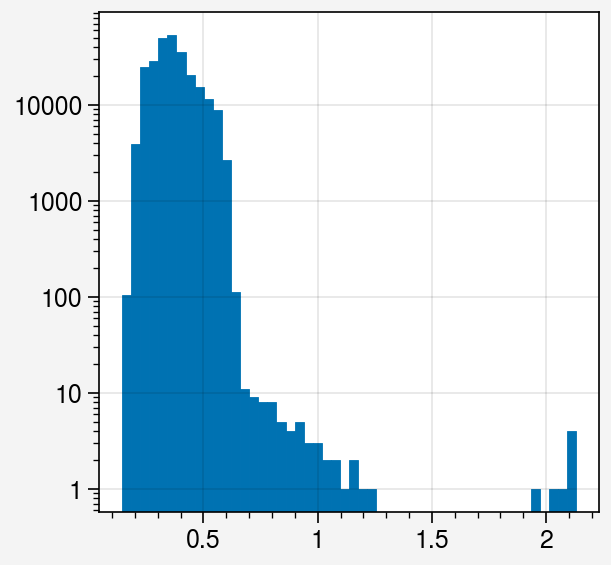

In [71]:
print(np.any(np.isnan(arr)))

fig, axs = pplt.subplots()
axs.hist(arr, bins=50, log=True);

64 1.6376420212384541 True
88 0.19133846163686902 True
108 0.0774758088925126 False
195 0.1708542685904516 False
316 0.07509398582793242 False
320 0.16392298180440687 True
321 0.07880602423625044 False
356 0.04057452211463708 True
366 0.09751429433684455 False
382 0.09050965679822445 False
389 0.0700532814363336 False
404 0.07842262657099208 False
407 0.07121362441751977 False
413 0.12851736660467733 True
437 0.09634881232655129 False


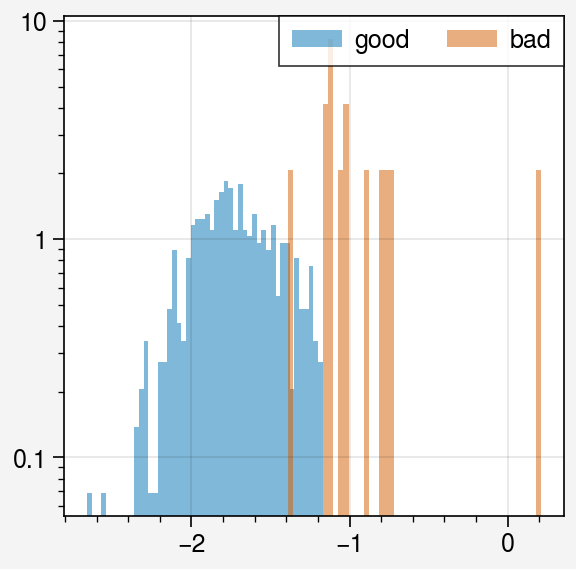

In [87]:
arr_bad = []
arr_good = []

def _stat(a):
    return np.nanmax(np.abs(a-np.nanmedian(a)))

ng = 512
for i in range(len(arr)//ng):
    start = i * ng
    stop = start + ng
    a = arr[start:stop]
    sa = _stat(a)
    if np.any(np.isnan(a)) or sa > 0.07:
        arr_bad.append(sa)
        print(i, arr_bad[-1], np.any(np.isnan(a)))
    else:
        arr_good.append(sa)
        
        
assert stop == len(arr)
arr_bad = np.log10(np.hstack(arr_bad))
arr_good = np.log10(np.hstack(arr_good))

fig, axs = pplt.subplots()
axs.hist(arr_good, bins=50, log=True, density=True, alpha=0.5, label="good")
axs.hist(arr_bad, bins=50, log=True, density=True, alpha=0.5, label="bad")
axs.legend()

In [48]:
TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]

with open(
    "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
    "%s_%s_pizza_cutter_info.yaml" % (TNAMES[1], BANDS[0])
) as fp:
    yml = yaml.safe_load(fp.read())

In [19]:
from des_y6utils.piff import (
    measure_star_t_for_piff_model,
    map_star_t_to_grid,
    measure_t_grid_for_piff_model,
    make_good_regions_for_piff_model_gal_grid,
    make_good_regions_for_piff_model_star_and_gal_grid,
    nanmad,
)

In [ ]:
# find a bad model
import tqdm

for sind, src in tqdm.tqdm(enumerate(yml["src_info"]), total=len(yml["src_info"])):
    fname = src["piff_path"]

    pmod = piff.read(fname)
    if "_z_" in fname:
        piff_kwargs = {"IZ_COLOR": 0.34}
    else:
        piff_kwargs = {"GI_COLOR": 0.61}
    t_gal = measure_t_grid_for_piff_model(piff_mod, piff_kwargs, seed=14354)    
    bf = np.mean(np.isnan(t_gal))
    
    if bf > 0:
        print(sind)
        break

In [66]:
from esutil.pbar import prange
from pizza_cutter.des_pizza_cutter._piff_tools import compute_piff_flags

tot = 0
flagged = 0

TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]


for i in prange(4):
    for j in range(4):
        with open(
            "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
            "%s_%s_pizza_cutter_info.yaml" % (TNAMES[i], BANDS[j])
        ) as fp:
            yml = yaml.safe_load(fp.read())
        
        for _sind, src in enumerate(yml["src_info"]):
            tot += 1
            if (compute_piff_flags(
                        piff_info=src["piff_info"],
                        max_fwhm_cen=3.6, 
                        min_nstar=35, 
                        max_exp_T_mean_fac=4, 
                        max_ccd_T_std_fac=0.3,
                    ) != 0):
                flagged += 1

print(flagged, flagged / tot)

|####################| 4/4 100% [elapsed: 00:20 left: 00:00]

33 0.012716763005780347


In [3]:
from pizza_cutter.des_pizza_cutter._piff_tools import compute_piff_flags

TNAMES = [
    "DES0131-3206", 
    "DES0137-3749", 
    "DES0221-0750", 
    "DES0229-0416",
]

tfind = "D00372620_i_c62_r5702p01_piff-model.fits"
BANDS = [tfind.split("_")[1]]
sind = None

for band in BANDS:
    for tname in TNAMES:
        with open(
            "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
            "%s_%s_pizza_cutter_info.yaml" % (tname, band)
        ) as fp:
            yml = yaml.safe_load(fp.read())

        for _sind, src in enumerate(yml["src_info"]):
            if tfind in src["piff_path"]:
                sind = _sind
                print(
                    "sind|flags|tname:",
                    sind,
                    compute_piff_flags(
                        piff_info=src["piff_info"],
                        max_fwhm_cen=3.6, 
                        min_nstar=25, 
                        max_exp_T_mean_fac=4, 
                        max_ccd_T_std_fac=0.3,
                    ),
                    yml["tilename"],
                )
                break
        if sind is not None:
            break
    if sind is not None:
        break


FileNotFoundError: [Errno 2] No such file or directory: '/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/DES0131-3206_i_pizza_cutter_info.yaml'

In [84]:
sind = 108

piff_mod = piff.read(fnames[sind])
print(len(piff_mod.stars))

if "_z_" in fnames[sind]:
    piff_kwargs = {"IZ_COLOR": 0.34}
else:
    piff_kwargs = {"GI_COLOR": 0.61}


83


In [85]:
thresh = 5
t_arr = measure_t_grid_for_piff_model(piff_mod, piff_kwargs, seed=14354)
data = measure_star_t_for_piff_model(piff_mod, piff_prop=list(piff_kwargs.keys())[0])
ts_arr = map_star_t_to_grid(data)

res_g = make_good_regions_for_piff_model_gal_grid(piff_mod, piff_kwargs=piff_kwargs, seed=11, verbose=False)
res_sg = make_good_regions_for_piff_model_star_and_gal_grid(
    piff_mod, piff_kwargs=piff_kwargs, seed=11, verbose=False,
    flag_bad_thresh=2, any_bad_thresh=5,
)

Text(0.5, 0, 'gal T - star T')

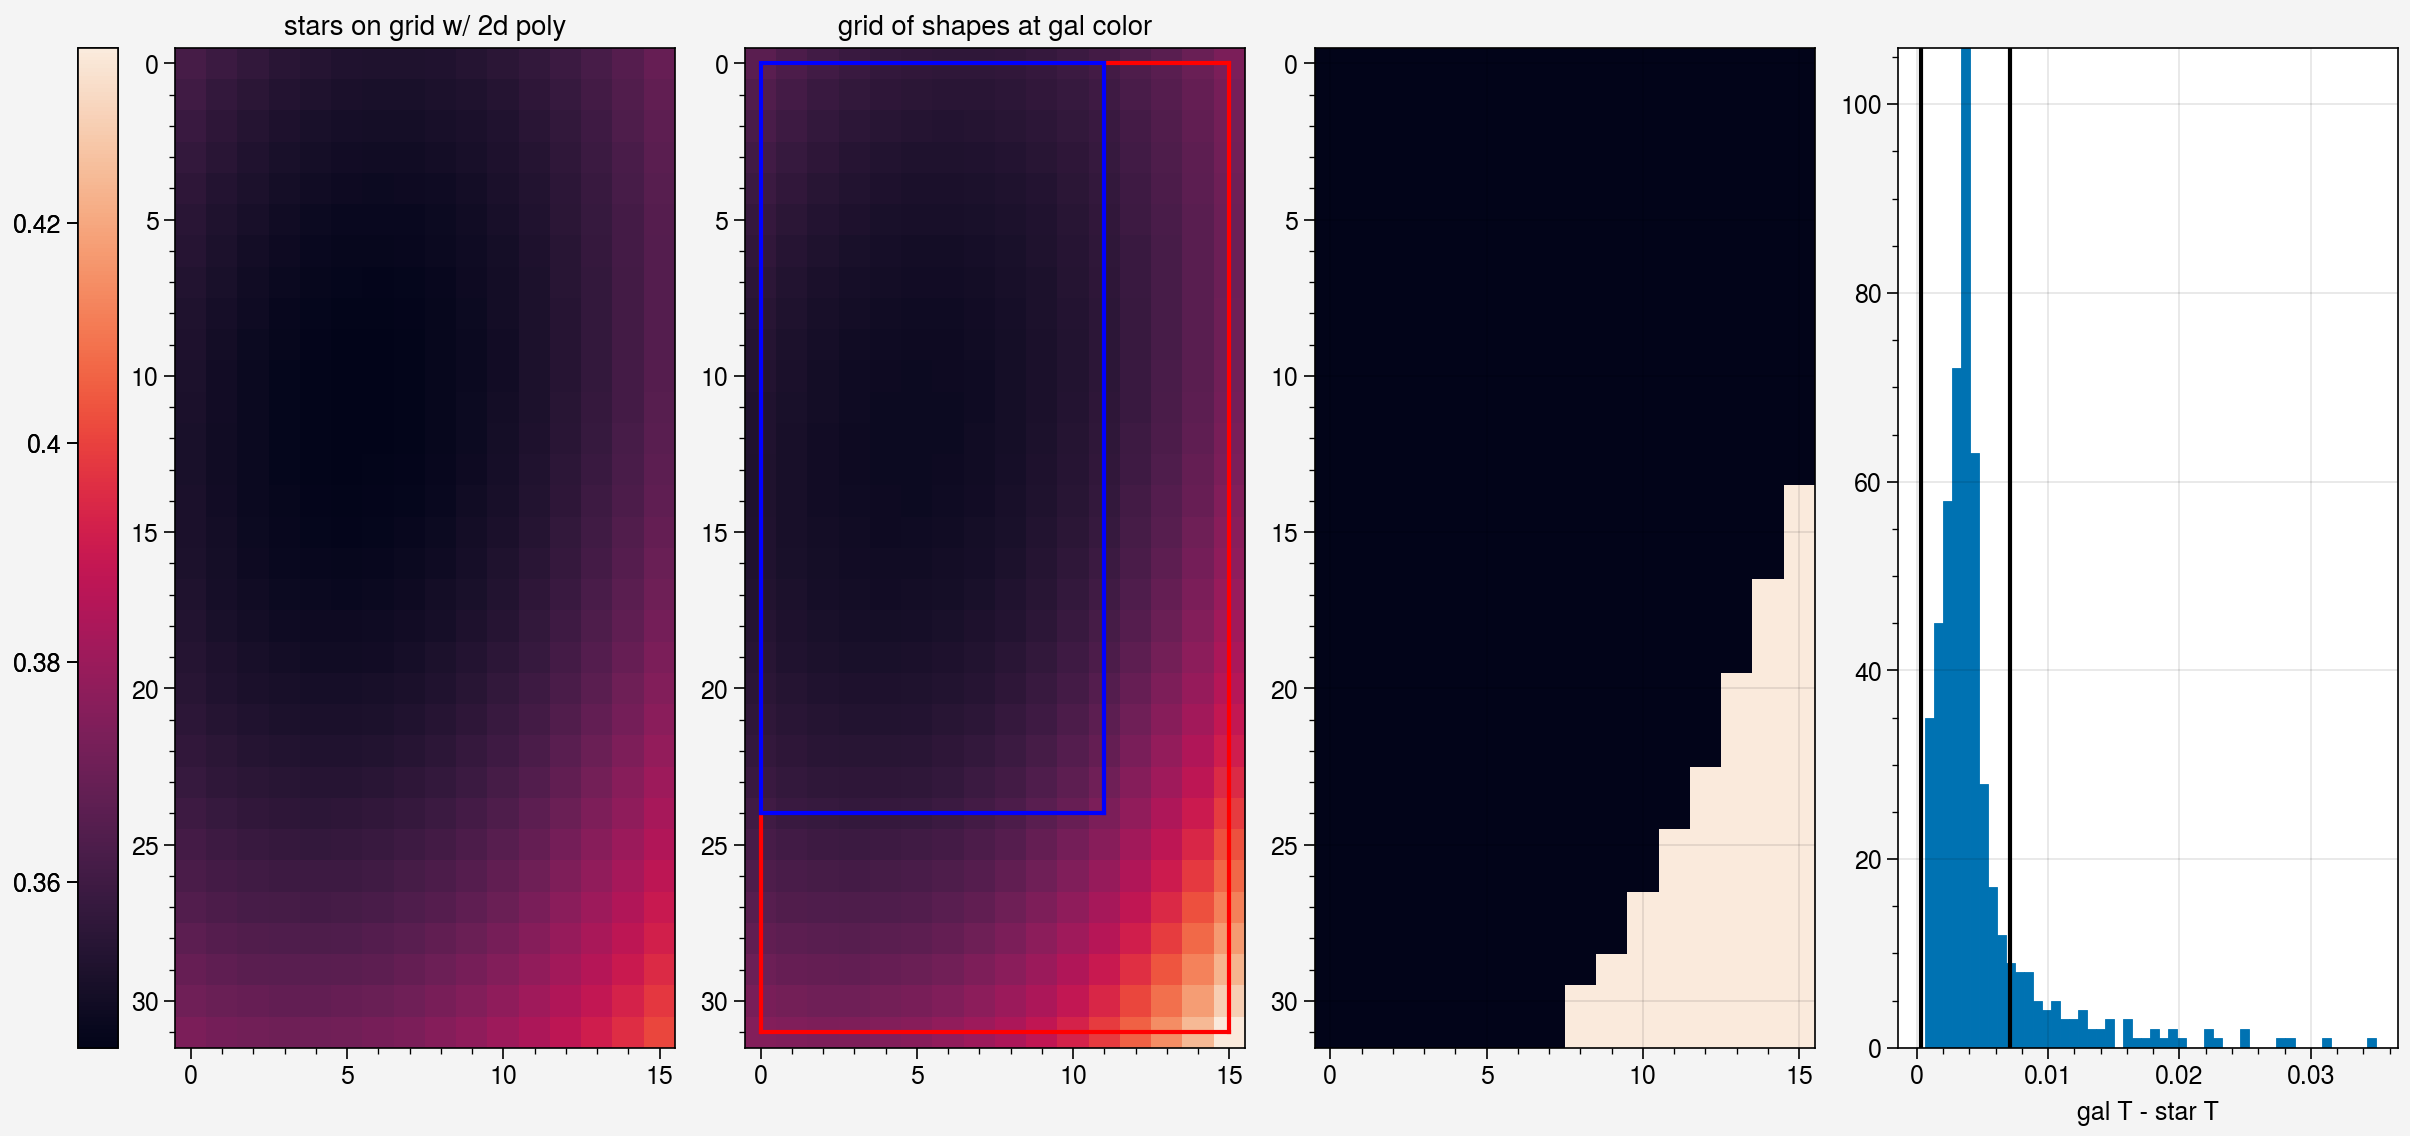

In [86]:
vmin = min(np.nanmin(ts_arr), np.nanmin(t_arr))
vmax = max(np.nanmax(ts_arr), np.nanmax(t_arr))

fig, axs = pplt.subplots(ncols=4, share=0)
h0 = axs[0].imshow(ts_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[0].grid(False)
axs[0].set_title("stars on grid w/ 2d poly")
axs[0].colorbar(h0, loc='l')

axs[1].imshow(t_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[1].grid(False)
axs[1].set_title("grid of shapes at gal color")

b = res_g["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="red")

b = res_sg["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="blue")

axs[2].imshow(res_sg["bad_msk"], cmap="rocket")

harr = (t_arr-ts_arr).ravel()
std5 = nanmad(harr) * 2
h = axs[3].hist(harr, bins=50)
axs[3].vlines([np.nanmedian(harr)-std5, np.nanmedian(harr)+std5], 0, np.max(h[0]), color="k")
axs[3].set_xlabel("gal T - star T")

In [80]:
np.nanmax(np.abs(harr - np.nanmedian(harr)))/nanmad(harr)

9.737691850582822

In [ ]:
np.mean(res_sg["bad_msk"])

In [17]:
t_gal[0, 0] = np.nan
np.mean(np.isnan(t_gal))

0.001953125

In [8]:
list(piff_kwargs.keys())[0]

'GI_COLOR'

In [ ]:
import ngmix

def get_star_stamp_pos(s, img, wgt):
    xint = int(np.floor(s.x - 1 + 0.5))
    yint = int(np.floor(s.y - 1 + 0.5))
    bbox = 17
    bbox_2 = (bbox - 1)//2
    
    return dict(
        img=img[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        wgt=wgt[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        xstart=xint-bbox_2, 
        ystart=yint-bbox_2,
        dim=bbox,
        x=s.x - 1,
        y=s.y - 1,
    )

def get_star_piff_obs(piff_mod, s, img, wgt):
    
    sres = get_star_stamp_pos(s, img, wgt)
    
    xv = sres["x"]+1
    yv = sres["y"]+1
    wcs = list(piff_mod.wcs.values())[0].local(
        image_pos=galsim.PositionD(x=xv, y=yv)
    ).jacobian()
    img = galsim.ImageD(sres["dim"], sres["dim"], wcs=wcs)
    cen = (
        sres["x"] - sres["xstart"] + 1,
        sres["y"] - sres["ystart"] + 1,
    )
    img = piff_mod.draw(
        x=xv, y=yv, chipnum=list(piff_mod.wcs.keys())[0],
        GI_COLOR=s.data.properties["GI_COLOR"],
        image=img, center=cen,
    )
    model_obs = ngmix.Observation(
        image=img.array,
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    star_obs = ngmix.Observation(
        image=sres["img"],
        weight=sres["wgt"],
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    return model_obs, star_obs, sres

In [ ]:

x = []
y = []
t = []

for s in piff_mod.stars:

    mobs, sobs, sres = get_star_piff_obs(piff_mod, s, img, wgt)
    
    res = ngmix.admom.AdmomFitter(
        rng=np.random.RandomState(seed=10)
    ).go(mobs, ngmix.moments.fwhm_to_T(1))
    t.append(res["T"])
    x.append(sres["x"])
    y.append(sres["y"])
    

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(np.array([x, y]).T, np.array(t))

In [ ]:
y, x = np.mgrid[0:4096:128, 0:2048:128] + 64
tg = polyreg.predict(np.array([x.ravel(), y.ravel()]).T)

In [ ]:
tg = tg.reshape(x.shape)

In [ ]:
fig, axs = pplt.subplots(ncols=2)
axs[0].imshow(tg)
axs[1].imshow(res["t_arr"])

In [ ]:
def _nanmad(x, axis=None):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis : {int, sequence of int, None}, optional
        `axis` keyword for

    Returns
    -------
    mad: float
        MAD of array x
    """
    return 1.4826*np.nanmedian(np.abs(x - np.nanmedian(x, axis=axis)), axis=axis)


In [ ]:
print(_nanmad(t), _nanmad(tg))

In [ ]:
from des_y6utils.piff import make_good_regions_for_piff_model

In [ ]:
res = make_good_regions_for_piff_model(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=10, verbose=False)

In [ ]:
res["t_std"]

In [ ]:
fig, axs = pplt.subplots()

axs.hist((res["t_arr"] - tg).ravel(), bins=50)

In [ ]:
np.std((res["t_arr"] - tg).ravel()) * 5

In [ ]:
np.max(np.abs(np.max(t) - np.median(t)))

In [ ]:
_nanmad(t)

In [ ]:
g = galsim.Gaussian(fwhm=0.5).dilate(1.1)

In [ ]:
g